- Use online detected spike for sorting
- Online detected spike has already be whitened

In [1]:
%reload_ext autoreload
%autoreload 2

from online_sorter_qtui import spike_data
from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

from scipy import signal 

from sklearn import *

from palettable.colorbrewer.qualitative import Dark2_4 as p4color

from utils import *

from time import sleep

np.random.seed(0)

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# load data
def loadPackets(filename):

    data_list = []
    segment_count = 0
    with open(filename,'rb') as f:
        while True:
            try:
                data_list.append(pickle.load(f))
                segment_count +=1
            except EOFError:
                break

        print(f'Reached end. Total segment: {segment_count}')
    return data_list

data_list = loadPackets('../data/data_packets_M2_D23_0610.pkl')
data_list = [d for d in data_list if d]

Reached end. Total segment: 42127


In [4]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df_spikes = makeSpikeDataframe(spikes_data)
df_spikes.sort_values('timestamps',inplace=True)
print(len(df_spikes))
df_spikes.head()


30308


,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[1.0382471, 0.267646, -0.31060556, -0.48534635...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,777492
1,"[-0.15610476, -0.78465533, -1.0079, -0.7250521...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,777700
2,"[-0.68814534, -0.6663029, -0.088886306, 0.2488...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,777896
3,"[-0.5647071, -0.7932088, -0.9721054, -0.733956...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,777929
4,"[0.9286076, 0.7933346, 0.7343918, 0.9987815, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,778174


(27, 7203840)
776320


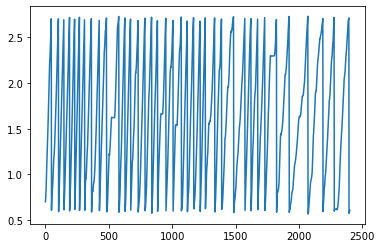

In [5]:
# collect the animal position
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]


In [26]:
# synchronize
df_spikes,_ = syncSpikeTime(df_spikes,neuroData)
df_spikes.head()

Match found at 513 on tetrode 1


,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[1.0382471, 0.267646, -0.31060556, -0.48534635...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,533.0
1,"[-0.15610476, -0.78465533, -1.0079, -0.7250521...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,741.0
2,"[-0.68814534, -0.6663029, -0.088886306, 0.2488...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,937.0
3,"[-0.5647071, -0.7932088, -0.9721054, -0.733956...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,970.0
4,"[0.9286076, 0.7933346, 0.7343918, 0.9987815, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,1215.0


In [11]:
# sorting
spikes2sort=5000 #15000
df_ref, df_online,template_cluster_id = sort_spikes_online(df_spikes.loc[:spikes2sort], df_spikes,pca_component=3)

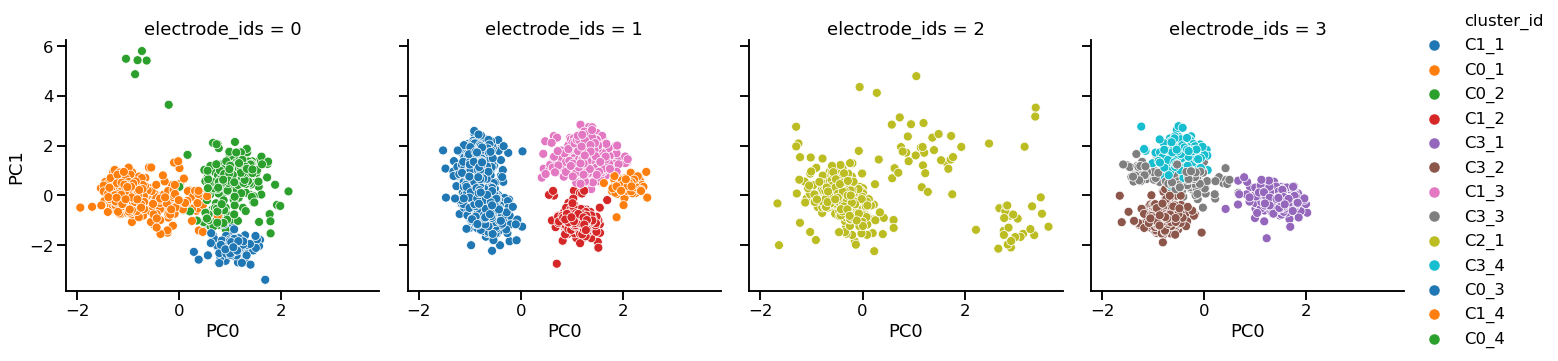

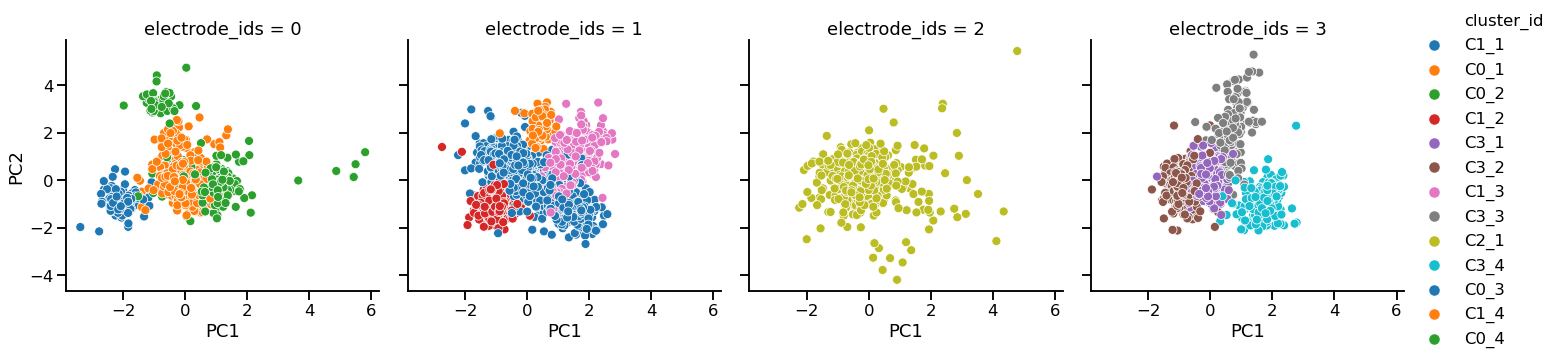

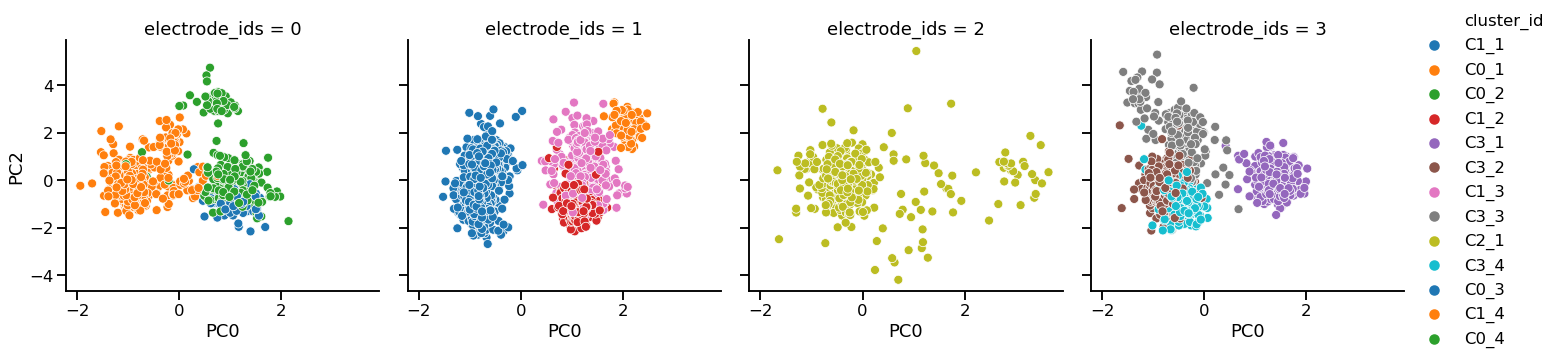

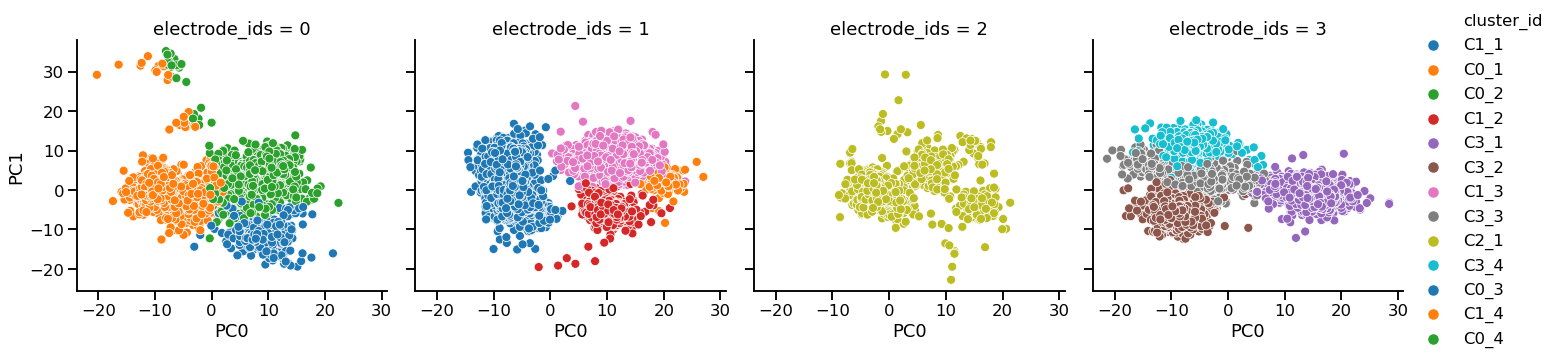

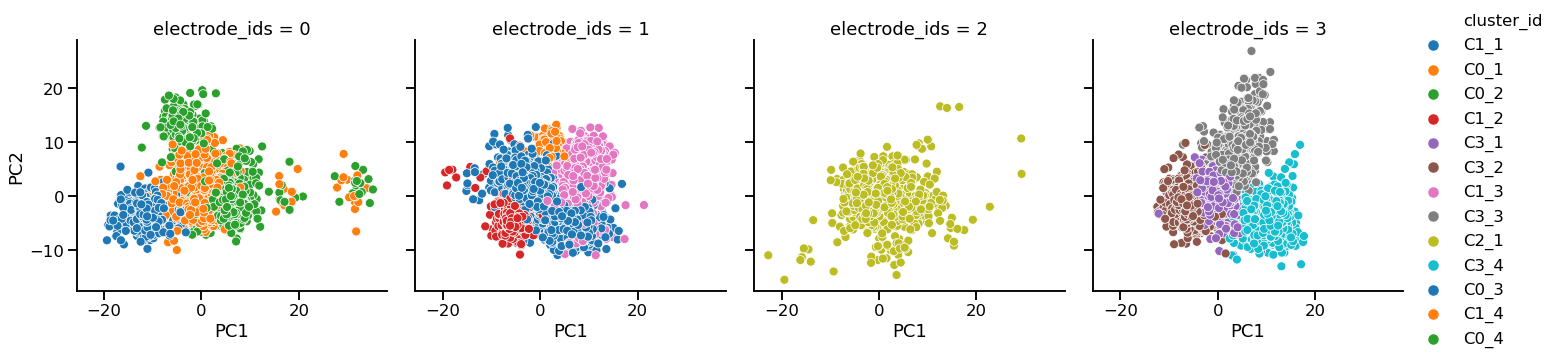

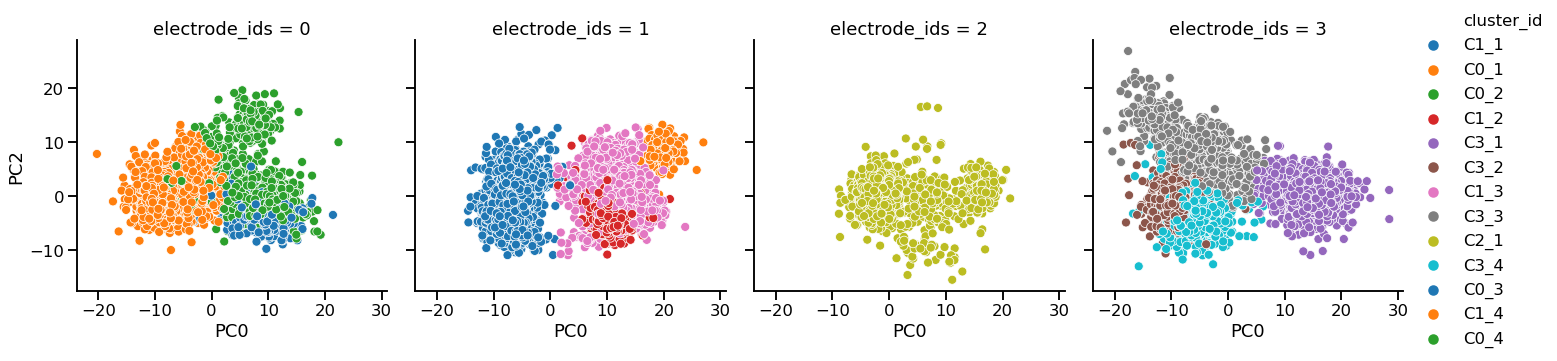

In [12]:
sns.set_context('talk',font_scale=1)

# training clustering
sns.relplot(x='PC0',y='PC1',hue='cluster_id', col='electrode_ids', col_wrap=4, palette='tab10', data=df_ref)
sns.relplot(x='PC1',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, palette='tab10', data=df_ref)
sns.relplot(x='PC0',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, palette='tab10',data=df_ref)


# testing clusters
sns.relplot(x='PC0',y='PC1',hue='cluster_id', col='electrode_ids', col_wrap=4, palette='tab10',data=df_online)
sns.relplot(x='PC1',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4,palette='tab10', data=df_online)
sns.relplot(x='PC0',y='PC2',hue='cluster_id', col='electrode_ids', col_wrap=4, palette='tab10',data=df_online)


(13, 2402)
(2402, 12)


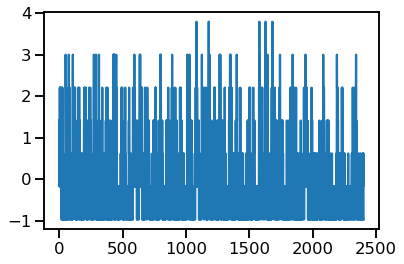

In [15]:
# make firing rate array
Fs = 30000
time_bin = 0.1
time_bin_start=0

df2decode = df_online

# convert to binned spiketrain
spike_time = (df2decode.timestamps.values)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max()+time_bin, time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df2decode.cluster_id, spike_time, bins)
print(spk_train.shape)

#normalize the firing rate
scaler =preprocessing.StandardScaler()
meanFr = spk_train.mean(axis=1)
norm_spiketrain = scaler.fit_transform(spk_train[meanFr>0.1,:].T)
print(norm_spiketrain.shape)
# norm_spiketrain=spk_train.T
plt.plot(norm_spiketrain[:,0])

### Train decoder

In [16]:
norm_pos_online = position 

data_length = min(norm_spiketrain.shape[0], norm_pos_online.shape[0])
norm_spiketrain = norm_spiketrain[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]

norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)


(0.0, 2000.0)

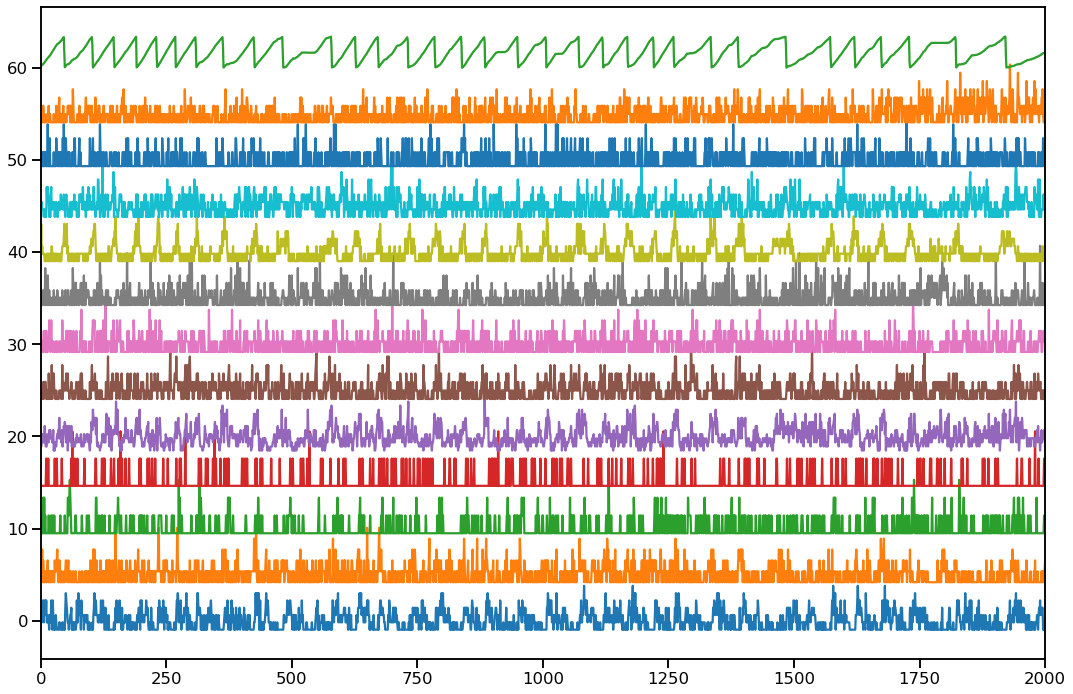

In [17]:
plt.figure(figsize=(18,12))
signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
plot_multichannel(signal2plot.T,scale=5)
plt.xlim([0,2000])
# plt.savefig('figures/aligned_fr.png')

0.4120253403001628 0.41212593997541536


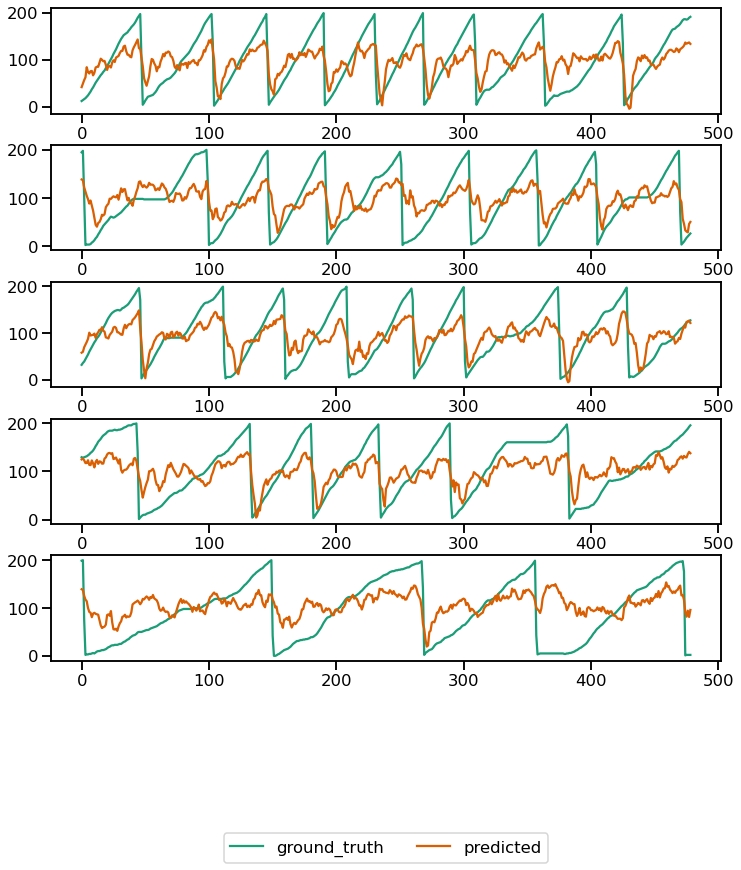

In [20]:
polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spiketrain)
poly_spiketrain = polyFeatures.transform(norm_spiketrain)

regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,norm_pos_online)
# regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')

# featureName = np.array(polyFeatures.get_feature_names())
# idx = np.argsort(-regressor.coef_**2) #sorted feature index, descending
# sortedFeatureName = featureName[idx]
# print(sortedFeatureName)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,norm_pos_online.ravel(),cv=4)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(norm_pos_online.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(norm_pos_online.squeeze(),predicted_smooth.ravel())
print(r2,varExplain)
stripplot(norm_pos_online,predicted_smooth,figsize=(12,12));


## Offline sorting using spike interface

In [1]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

NameError: name 'adc_data' is not defined

In [143]:
 #required for mountasort to store intermediate data
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmp6fpmdcde
Num. workers = 2
Preparing C:\tmp\tmp6fpmdcde/timeseries.hdf5...
'end_frame' set to 13849600
Preparing neighborhood sorters (M=16, N=13849600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmp6fpmdcde
mountainsort4 run time 145.57s


In [144]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())


Impossible to delete temp file: C:\Users\teristam\AppData\Local\Temp\tmpbjb6p_g6 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\teristam\\AppData\\Local\\Temp\\tmpbjb6p_g6\\waveforms_1.raw'
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]


In [145]:
time_bin_start = 0
bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain=np.stack(spiketrain)    

# make frame for plotting
df_ms4 = makeTuningDataframe(position, spiketrain.T,time_bin)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



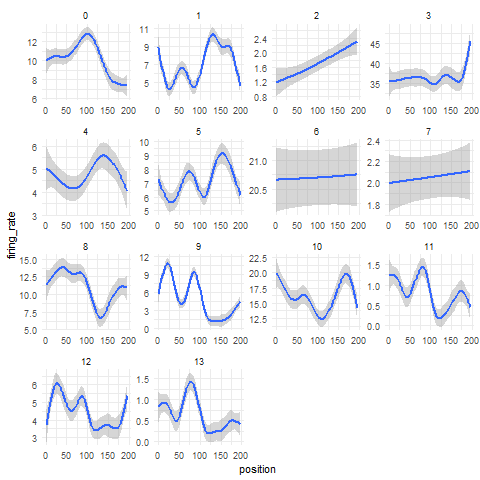

In [146]:
%%R -i df_ms4
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df_ms4) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
    
# ggsave('ms4_tuningcurve.pdf')